IMPORTING LIBRARIES

In [8]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from fbprophet import Prophet

from pandas import to_datetime

import itertools
import warnings

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import datetime
from datetime import datetime
warnings.filterwarnings('ignore')

Local installation for Pmdarima

In [2]:
!pip install pmdarima

     |████████████████████████████████| 1.5 MB 5.3 MB/s 
     |████████████████████████████████| 9.5 MB 31.6 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [10]:
# Connect to Google Drive to pull datasets
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Import main Dataset For Product C

In [17]:
df = pd.read_csv('gdrive/My Drive/YonVitra/TimeSeriesC.csv')
df

,Date,Quantity
0,2017-01-01,29711
1,2017-02-01,23747
2,2017-03-01,31078
3,2017-04-01,22364
4,2017-05-01,23920
5,2017-06-01,15187
6,2017-07-01,14064
7,2017-08-01,18948
8,2017-09-01,30367
9,2017-10-01,17021


**Visualizing a time series**

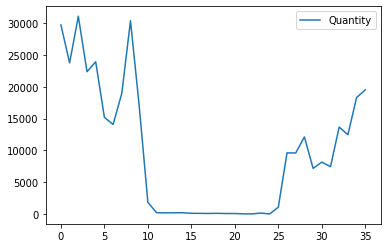

In [18]:
df.plot()

You can group the data at seasonal intervals and see how the values are distributed within a given year or month and how it compares over time.

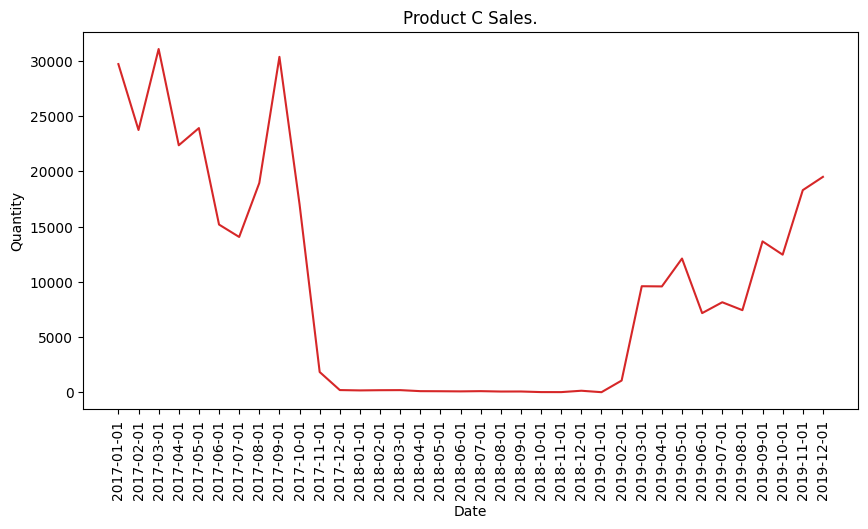

In [19]:
import matplotlib.pyplot as plt
# Draw Plot
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Quantity', dpi=100):
    plt.figure(figsize=(10,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.xticks(range(len(x)),x,rotation='vertical')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
    

plot_df(df, x=df.Date, y=df.Quantity, title='Product C Sales.')  

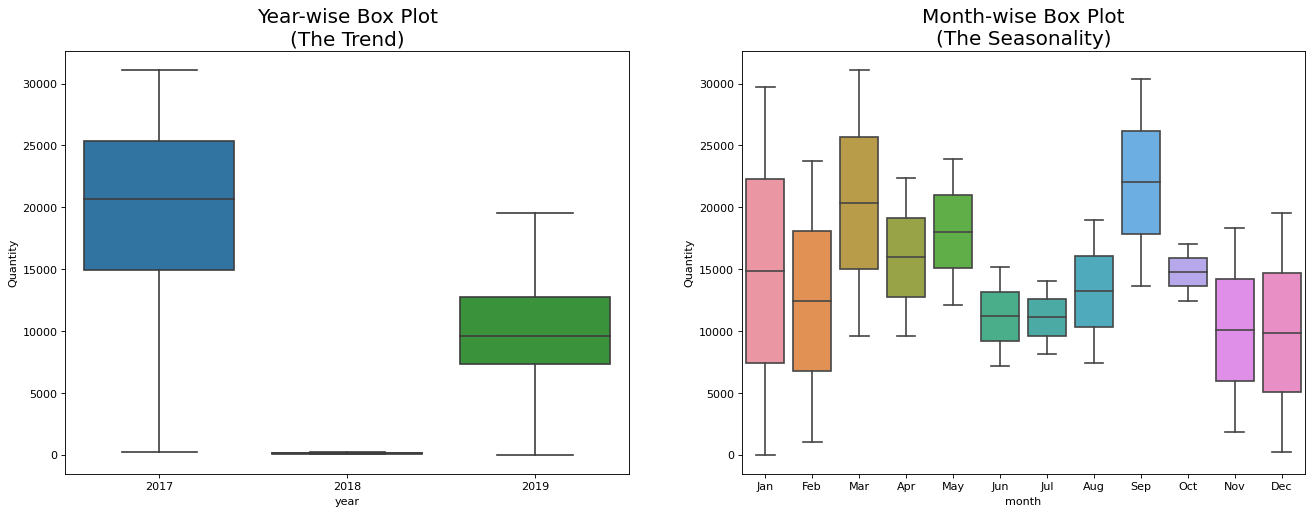

In [20]:
df = pd.read_csv('gdrive/My Drive/YonVitra/TimeSeriesC.csv', parse_dates=['Date'], index_col='Date')
df.reset_index(inplace=True)

# Prepare data
df['year'] = [d.year for d in df.Date]
df['month'] = [d.strftime('%b') for d in df.Date]
years = df['year'].unique()
# Draw Plot
import seaborn as sns
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='Quantity', data=df, ax=axes[0])
sns.boxplot(x='month', y='Quantity', data=df.loc[df.year.isin([2017, 2019]), :]) #?

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

**Test For Stationarity**

P-Value test is less than the significance level (0.05), you reject the null hypothesis.

In [21]:
from statsmodels.tsa.stattools import adfuller
print('Result of Dickey-Fuller Test: ')
dftest = adfuller(df['Quantity'], autolag ='AIC')

dfout = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 'LAgs', 'Number of Observation'])
for key,value in dftest[4].items():
  dfout['Critical Value(%s) '%key] = value

print(dfout)

Result of Dickey-Fuller Test: 
Test Statistic           -1.612232
p-value                   0.476804
LAgs                      3.000000
Number of Observation    32.000000
Critical Value(1%)       -3.653520
Critical Value(5%)       -2.957219
Critical Value(10%)      -2.617588
dtype: float64


In [22]:
df.set_index('Date',inplace=True)

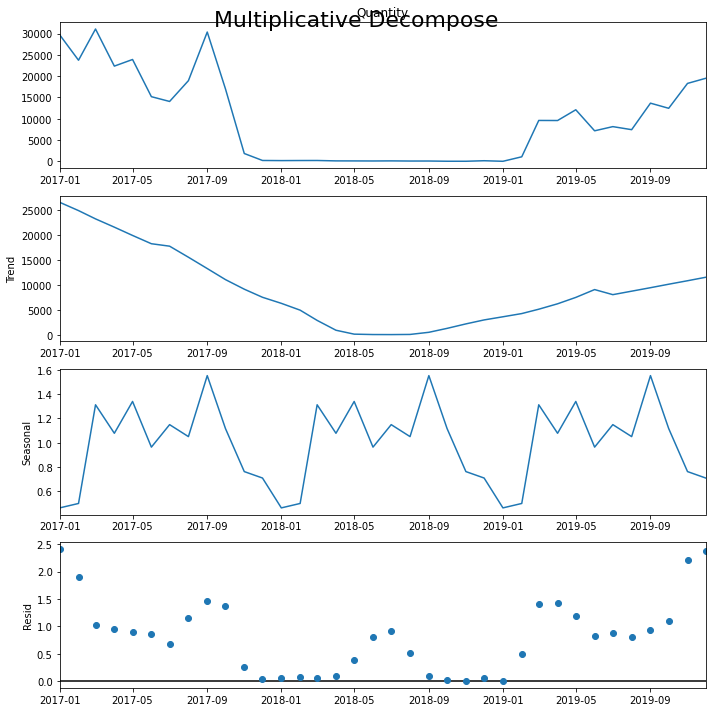

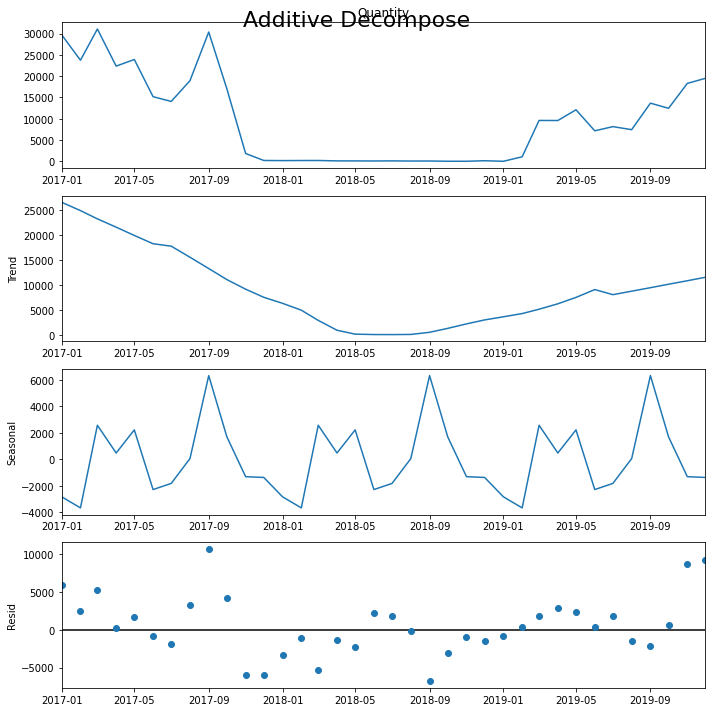

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose
df = pd.read_csv('gdrive/My Drive/YonVitra/TimeSeriesC.csv', parse_dates=['Date'], index_col='Date')

# Multiplicative Decomposition 
result_mul = seasonal_decompose(df['Quantity'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(df['Quantity'], model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

Text(0.5, 1.0, 'Product C Sales detrended by subtracting the least squares fit')

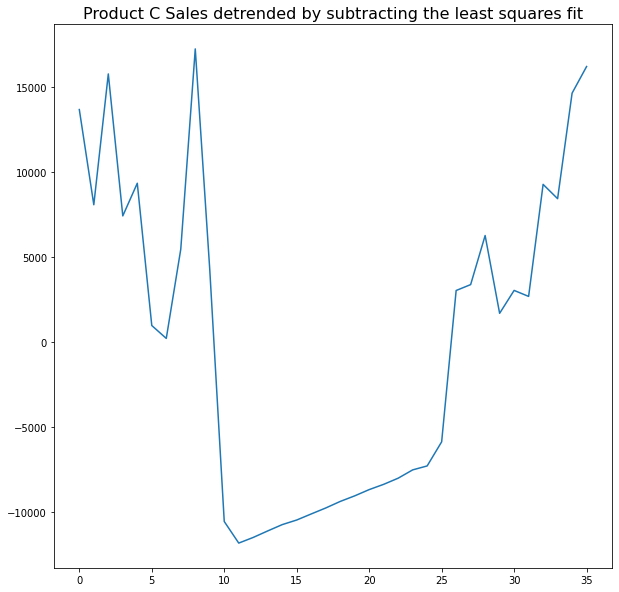

In [24]:
# Using scipy: Subtract the line of best fit
from scipy import signal
detrended = signal.detrend(df.Quantity.values)
plt.plot(detrended)
plt.title('Product C Sales detrended by subtracting the least squares fit', fontsize=16)

[]

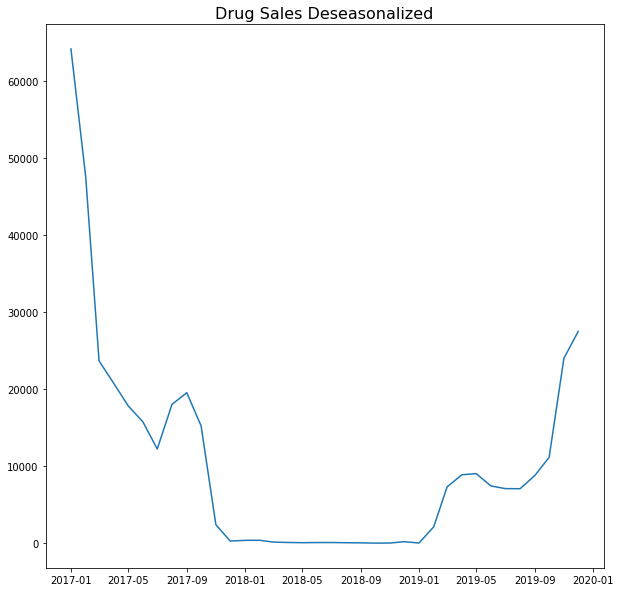

In [25]:
# Subtracting the Trend Component.
df = pd.read_csv('gdrive/My Drive/YonVitra/TimeSeriesC.csv', parse_dates=['Date'], index_col='Date')

# Time Series Decomposition
result_mul = seasonal_decompose(df['Quantity'], model='multiplicative', extrapolate_trend='freq')

# Deseasonalize
deseasonalized = df.Quantity.values / result_mul.seasonal

# Plot
plt.plot(deseasonalized)
plt.title('Drug Sales Deseasonalized', fontsize=16)
plt.plot()

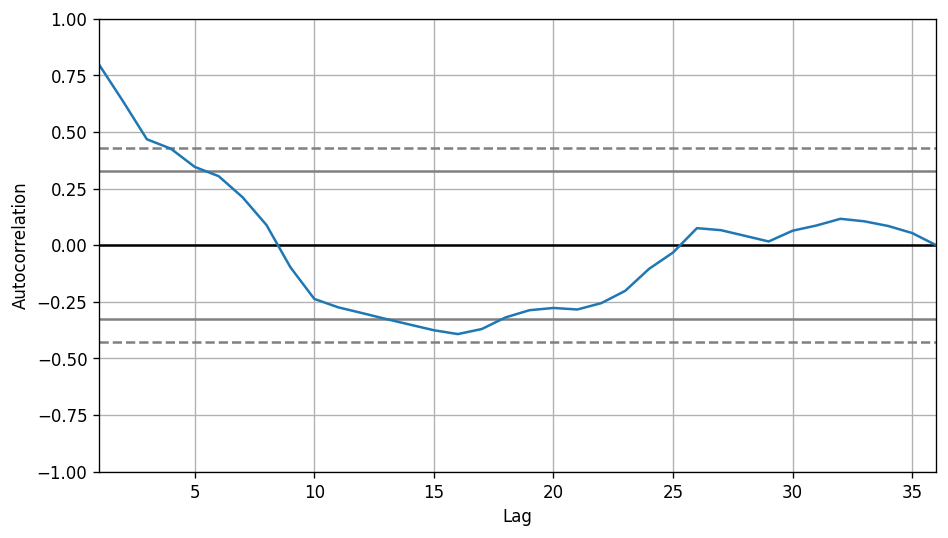

In [26]:
from pandas.plotting import autocorrelation_plot
df = pd.read_csv('gdrive/My Drive/YonVitra/TimeSeriesC.csv')

# Draw Plot
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
autocorrelation_plot(df.Quantity.tolist())

Converting Date Column to Date format

In [28]:
df['Date'] =  pd.to_datetime(df['Date'],
                              format='%Y-%m-%d')

In [29]:
df['Date'] = df['Date'].dt.date
df

,Date,Quantity
0,2017-01-01,29711
1,2017-02-01,23747
2,2017-03-01,31078
3,2017-04-01,22364
4,2017-05-01,23920
5,2017-06-01,15187
6,2017-07-01,14064
7,2017-08-01,18948
8,2017-09-01,30367
9,2017-10-01,17021


To train the model, we divide the data we have into two as train and test.

In [58]:
X_train = df[0:25]
X_valid = df[24:36]

print('X_train Shape', X_train.shape)
print('X_Valid Shape', X_valid.shape)

X_train['Date'].unique()

X_train Shape (25, 2)
X_Valid Shape (12, 2)


array([datetime.date(2017, 1, 1), datetime.date(2017, 2, 1),
       datetime.date(2017, 3, 1), datetime.date(2017, 4, 1),
       datetime.date(2017, 5, 1), datetime.date(2017, 6, 1),
       datetime.date(2017, 7, 1), datetime.date(2017, 8, 1),
       datetime.date(2017, 9, 1), datetime.date(2017, 10, 1),
       datetime.date(2017, 11, 1), datetime.date(2017, 12, 1),
       datetime.date(2018, 1, 1), datetime.date(2018, 2, 1),
       datetime.date(2018, 3, 1), datetime.date(2018, 4, 1),
       datetime.date(2018, 5, 1), datetime.date(2018, 6, 1),
       datetime.date(2018, 7, 1), datetime.date(2018, 8, 1),
       datetime.date(2018, 9, 1), datetime.date(2018, 10, 1),
       datetime.date(2018, 11, 1), datetime.date(2018, 12, 1),
       '2019-01-01'], dtype=object)

Check Statinority For Train Data

In [31]:
from statsmodels.tsa.stattools import adfuller, kpss
# ADF Test
result = adfuller(X_train.Quantity.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(X_train.Quantity.values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -1.8362290527215297
p-value: 0.36262902564083865
Critial Values:
   1%, -3.8092091249999998
Critial Values:
   5%, -3.0216450000000004
Critial Values:
   10%, -2.6507125

KPSS Statistic: 0.359938
p-value: 0.094423
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


In [59]:
X_train.set_index('Date',inplace=True)
X_train

,Quantity
Date,
2017-01-01,29711
2017-02-01,23747
2017-03-01,31078
2017-04-01,22364
2017-05-01,23920
2017-06-01,15187
2017-07-01,14064
2017-08-01,18948
2017-09-01,30367


Since P-Value is greater than 0.05, using two method(log transform/ differentiate) trying to make our data to stationary.

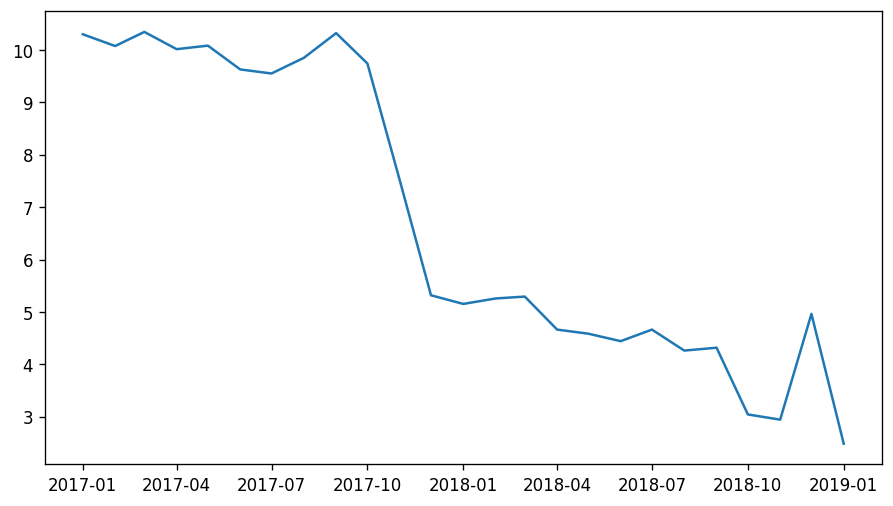

In [33]:
from numpy import log
from matplotlib import pyplot
logTrans = log(X_train)
pyplot.plot(logTrans)

In [34]:
from statsmodels.tsa.stattools import adfuller, kpss

# ADF Test
result = adfuller(logTrans['Quantity'].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(logTrans['Quantity'].values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -0.5832208104463623
p-value: 0.8747285403649916
Critial Values:
   1%, -3.7377092158564813
Critial Values:
   5%, -2.9922162731481485
Critial Values:
   10%, -2.635746736111111

KPSS Statistic: 0.371967
p-value: 0.089238
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


 We will try the differentiate method since Log Transform does not decrease the p-value

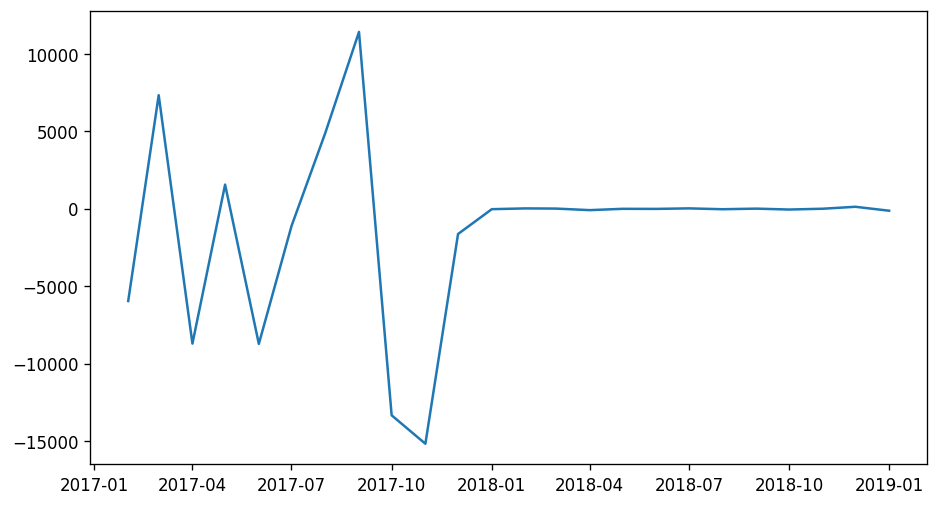

In [60]:
diff = X_train.diff()
diff.dropna(inplace=True)
pyplot.plot(diff)

In [61]:
from statsmodels.tsa.stattools import adfuller, kpss

# ADF Test
result = adfuller(diff['Quantity'].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(diff['Quantity'].values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -4.031513362858371
p-value: 0.001254196360392457
Critial Values:
   1%, -3.769732625845229
Critial Values:
   5%, -3.005425537190083
Critial Values:
   10%, -2.6425009917355373

KPSS Statistic: 0.266427
p-value: 0.100000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


The differentiate method succeeded in making our data stationary. Now we can move on to training.

Autocorrelation is simply the correlation of a series with its own lags. If a series is significantly autocorrelated, that means, the previous values of the series (lags) may be helpful in predicting the current value.Partial Autocorrelation also conveys similar information but it conveys the pure correlation of a series and its lag, excluding the correlation contributions from the intermediate lags.

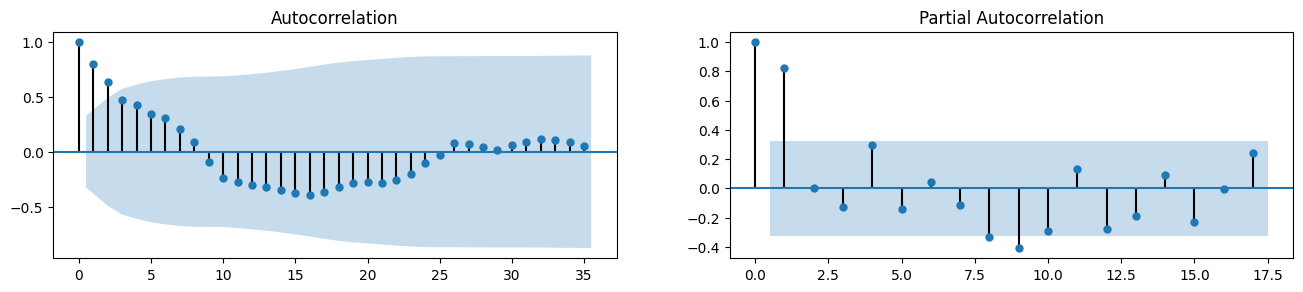

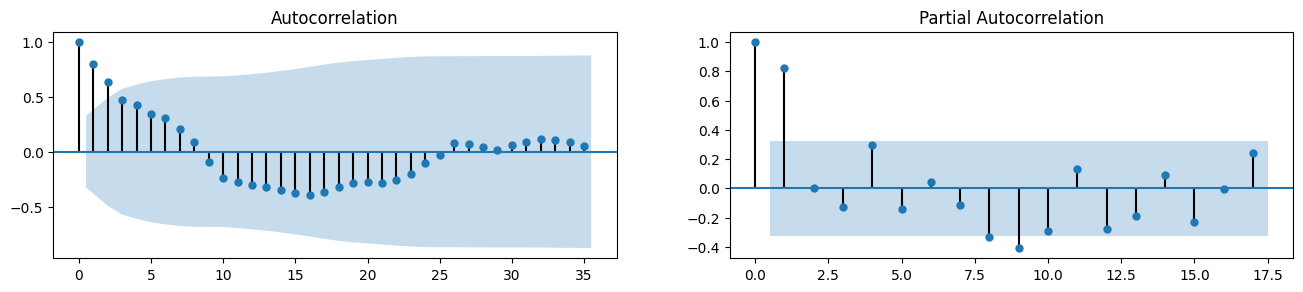

In [ ]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Calculate ACF and PACF upto 50 lags
# acf_50 = acf(df.value, nlags=50)
# pacf_50 = pacf(df.value, nlags=50)

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df.Quantity.tolist(), lags=35, ax=axes[0])
plot_pacf(df.Quantity.tolist(),lags=17, ax=axes[1])

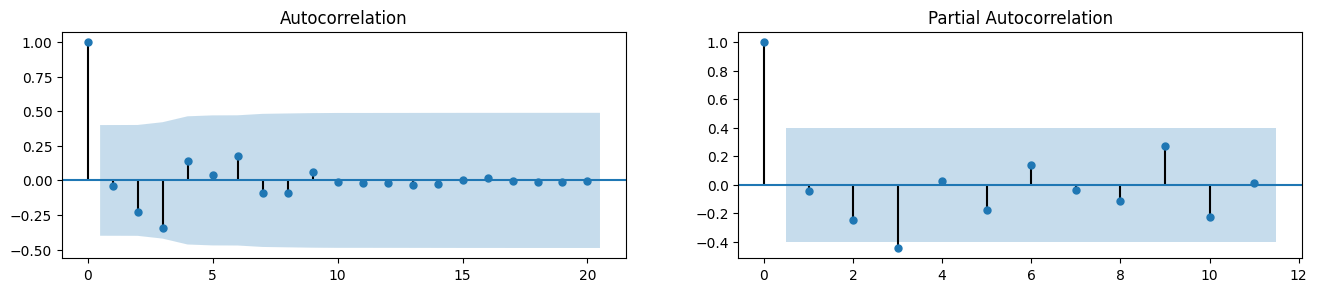

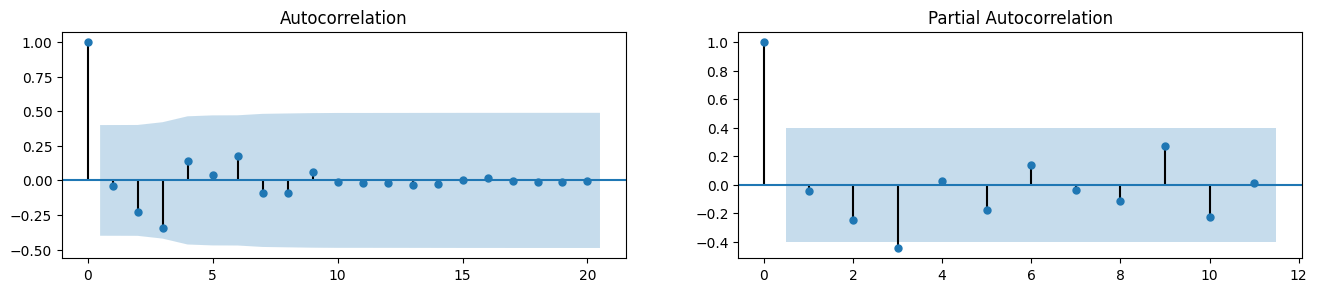

In [38]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Calculate ACF and PACF upto 50 lags
# acf_50 = acf(df.value, nlags=50)
# pacf_50 = pacf(df.value, nlags=50)

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(diff.Quantity.tolist(), lags=20, ax=axes[0])
plot_pacf(diff.Quantity.tolist(),lags=11, ax=axes[1])

Test Date Range For Prediction

In [62]:
# Setting the Index for 12 months
index_12_months = pd.date_range(X_train.index[-1], freq='MS', periods = 12) 

index_12_months

DatetimeIndex(['2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
               '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
               '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01'],
              dtype='datetime64[ns]', freq='MS')

We are looking for the values that give the least error value in the order parameter to use in the Arima model.

In [ ]:
import itertools
p=d=q=range(0,7)
pdq = list(itertools.product(p,d,q))

for param in pdq:
    try:
        model_arima = ARIMA(diff,order=param)
        model_arima_fit = model_arima.fit()
        print(param,model_arima_fit.aic)
    except:
        continue

(0, 0, 0) 487.04717790064467
(0, 0, 1) 488.97460790947036
(0, 0, 2) 488.84504228970553
(0, 0, 3) 487.99539487611673
(0, 0, 4) 487.5303387201461
(0, 0, 5) 488.32992256212776
(0, 0, 6) 490.0491519751539
(0, 1, 0) 484.36443136380626
(0, 1, 1) 472.5517301870966
(0, 1, 2) 474.54477235894035
(0, 1, 3) 473.32243058183633
(0, 1, 4) 472.9374766568508
(0, 1, 5) 471.32766801954995
(0, 2, 0) 485.8003184400163
(0, 2, 1) 469.5665348572229
(0, 2, 2) 461.69858873506894
(0, 2, 3) 463.6273872576385
(0, 2, 4) 464.4989035086088
(0, 2, 5) 464.7405628612611
(1, 0, 0) 489.01070026894655
(1, 1, 0) 482.5725579295385
(1, 1, 1) 496.8237660314733
(1, 2, 0) 478.38506729938706
(1, 2, 1) 468.60445842064746
(1, 2, 2) 473.56817188679236
(1, 2, 3) 465.69930790248304
(1, 2, 6) 467.5583616730064
(2, 0, 0) 489.67899536307095
(2, 0, 2) 497.7413780804519
(2, 1, 0) 483.2191705788873
(2, 1, 1) 501.93903761258406
(2, 2, 0) 478.8620864636915
(2, 2, 1) 469.6922120572592
(2, 2, 4) 468.8750069383217
(3, 0, 0) 487.96952978713705
(3

In [73]:
from sklearn.metrics import mean_squared_error

# Running ARIMA with random numbers
model_arima = ARIMA(diff, order=(4,1,1)) 
model_arima_fit = model_arima.fit(disp=-1)

# Saving ARIMA predictions
fcast1 = model_arima_fit.forecast(12)[0]

# Passing the same index as the others
fcast1 = pd.Series(fcast1, index=index_12_months)
fcast1 = fcast1.rename("Arima") 
print(fcast1)

print(fcast1.values)
print('The MSE of ARIMA is:', mean_squared_error(X_valid['Quantity'].values, fcast1.values, squared=False))

2019-01-01    5540.380290
2019-02-01    1473.229286
2019-03-01    1151.058625
2019-04-01    1513.751193
2019-05-01    3672.192179
2019-06-01    2823.819519
2019-07-01    2186.233218
2019-08-01    2451.093665
2019-09-01    3419.193306
2019-10-01    3394.470560
2019-11-01    3077.028835
2019-12-01    3199.424992
Freq: MS, Name: Arima, dtype: float64
[5540.38029009 1473.22928586 1151.05862477 1513.75119337 3672.1921794
 2823.81951895 2186.23321754 2451.09366522 3419.19330605 3394.47055968
 3077.02883503 3199.4249923 ]
The MSE of ARIMA is: 9140.77870784738


**SHOWING PREDICTIONS ON THE DATAFRAME**

In [74]:
forecastLast = pd.DataFrame({'Date':fcast1.index, 'Quantity':fcast1.values})

In [75]:
forecastLast['Quantity'] = forecastLast['Quantity'].astype(int)

In [76]:
forecastLast

,Date,Quantity
0,2019-01-01,5540
1,2019-02-01,1473
2,2019-03-01,1151
3,2019-04-01,1513
4,2019-05-01,3672
5,2019-06-01,2823
6,2019-07-01,2186
7,2019-08-01,2451
8,2019-09-01,3419
9,2019-10-01,3394


In [77]:
X_valid.reset_index(inplace=True)

In [78]:
X_valid.rename({'Quantity': 'Actual Sales'}, axis=1, inplace=True)
X_valid

,index,Date,Actual Sales
0,24,2019-01-01,12
1,25,2019-02-01,1066
2,26,2019-03-01,9604
3,27,2019-04-01,9587
4,28,2019-05-01,12110
5,29,2019-06-01,7170
6,30,2019-07-01,8153
7,31,2019-08-01,7437
8,32,2019-09-01,13663
9,33,2019-10-01,12459


In [79]:
X_valid['Date'] =X_valid['Date'].apply(str)

In [80]:
forecastLast['Date'] =forecastLast['Date'].dt.date

In [81]:
forecastLast['Quantity'] = forecastLast['Quantity'].astype(int)

In [82]:
forecastLast['Date'] =forecastLast['Date'].apply(str) 

In [83]:
forecastLast = pd.merge(forecastLast,X_valid, on='Date')
forecastLast

,Date,Quantity,index,Actual Sales
0,2019-01-01,5540,24,12
1,2019-02-01,1473,25,1066
2,2019-03-01,1151,26,9604
3,2019-04-01,1513,27,9587
4,2019-05-01,3672,28,12110
5,2019-06-01,2823,29,7170
6,2019-07-01,2186,30,8153
7,2019-08-01,2451,31,7437
8,2019-09-01,3419,32,13663
9,2019-10-01,3394,33,12459


In [84]:
forecastLast['Shift'] = forecastLast['Quantity'].shift(1)
forecastLast.dropna(inplace=True)
forecastLast

,Date,Quantity,index,Actual Sales,Shift
1,2019-02-01,1473,25,1066,5540.0
2,2019-03-01,1151,26,9604,1473.0
3,2019-04-01,1513,27,9587,1151.0
4,2019-05-01,3672,28,12110,1513.0
5,2019-06-01,2823,29,7170,3672.0
6,2019-07-01,2186,30,8153,2823.0
7,2019-08-01,2451,31,7437,2186.0
8,2019-09-01,3419,32,13663,2451.0
9,2019-10-01,3394,33,12459,3419.0
10,2019-11-01,3077,34,18302,3394.0


In [85]:
forecastLast['ForecastPred'] = forecastLast['Shift'] + forecastLast['Quantity']
forecastLast

,Date,Quantity,index,Actual Sales,Shift,ForecastPred
1,2019-02-01,1473,25,1066,5540.0,7013.0
2,2019-03-01,1151,26,9604,1473.0,2624.0
3,2019-04-01,1513,27,9587,1151.0,2664.0
4,2019-05-01,3672,28,12110,1513.0,5185.0
5,2019-06-01,2823,29,7170,3672.0,6495.0
6,2019-07-01,2186,30,8153,2823.0,5009.0
7,2019-08-01,2451,31,7437,2186.0,4637.0
8,2019-09-01,3419,32,13663,2451.0,5870.0
9,2019-10-01,3394,33,12459,3419.0,6813.0
10,2019-11-01,3077,34,18302,3394.0,6471.0


In [86]:
forecastLast.drop(['Shift','Quantity'],axis=1,inplace=True)

**PREDICTIONS ON TEST DATA**

In [87]:
forecastLast

,Date,index,Actual Sales,ForecastPred
1,2019-02-01,25,1066,7013.0
2,2019-03-01,26,9604,2624.0
3,2019-04-01,27,9587,2664.0
4,2019-05-01,28,12110,5185.0
5,2019-06-01,29,7170,6495.0
6,2019-07-01,30,8153,5009.0
7,2019-08-01,31,7437,4637.0
8,2019-09-01,32,13663,5870.0
9,2019-10-01,33,12459,6813.0
10,2019-11-01,34,18302,6471.0


In [88]:
X_valid.set_index('Date',inplace=True)

For 2020 Prediction get date range

In [89]:
index_4_months = pd.date_range(X_valid.index[-1], freq='MS', periods = 5) 

index_4_months

DatetimeIndex(['2019-12-01', '2020-01-01', '2020-02-01', '2020-03-01',
               '2020-04-01'],
              dtype='datetime64[ns]', freq='MS')

In [90]:
df.set_index('Date',inplace=True)

In [113]:
# Running ARIMA with random numbers
model_arima = ARIMA(diff, order=(4,1,1)) #0-1-5
model_arima_fit = model_arima.fit(disp=-1)

# Saving ARIMA predictions
fcast1 = model_arima_fit.forecast(5)[0]

# Passing the same index as the others
fcast1 = pd.Series(fcast1, index=index_4_months)
fcast1 = fcast1.rename("Arima") 
print(fcast1)

2019-12-01    5540.380290
2020-01-01    1473.229286
2020-02-01    1151.058625
2020-03-01    1513.751193
2020-04-01    3672.192179
Freq: MS, Name: Arima, dtype: float64


In [96]:
forecastLast2020 = pd.DataFrame({'Date':fcast1.index, 'Quantity':fcast1.values})

In [97]:
forecastLast2020['Quantity'] = forecastLast2020['Quantity'].astype(int)

In [98]:
forecastLast2020

,Date,Quantity
0,2019-12-01,5540
1,2020-01-01,1473
2,2020-02-01,1151
3,2020-03-01,1513
4,2020-04-01,3672


In [99]:
forecastLast2020['Shift'] = forecastLast2020['Quantity'].shift(1)
forecastLast2020

,Date,Quantity,Shift
0,2019-12-01,5540,NaN
1,2020-01-01,1473,5540.0
2,2020-02-01,1151,1473.0
3,2020-03-01,1513,1151.0
4,2020-04-01,3672,1513.0


In [100]:
forecastLast2020['ForecastPred'] = forecastLast2020['Shift'] + forecastLast2020['Quantity']
forecastLast2020

,Date,Quantity,Shift,ForecastPred
0,2019-12-01,5540,NaN,NaN
1,2020-01-01,1473,5540.0,7013.0
2,2020-02-01,1151,1473.0,2624.0
3,2020-03-01,1513,1151.0,2664.0
4,2020-04-01,3672,1513.0,5185.0


In [101]:
forecastLast2020.dropna(inplace=True)

**PREDICTIONS FOR 2020**

In [102]:
forecastLast2020

,Date,Quantity,Shift,ForecastPred
1,2020-01-01,1473,5540.0,7013.0
2,2020-02-01,1151,1473.0,2624.0
3,2020-03-01,1513,1151.0,2664.0
4,2020-04-01,3672,1513.0,5185.0


**AUTO ARIMA PREDICTIONS**

In [ ]:
pip install pmdarima

In [114]:
import pmdarima as pm

In [126]:
# Running auto ARIMA 
auto_arima_model = pm.auto_arima(df, seasonal=False, m=5)

# Read more about setting m
# https://alkaline-ml.com/pmdarima/tips_and_tricks.html

# make your forecasts
fcast2 = auto_arima_model.predict(5) 
fcast2 = pd.Series(fcast2, index=index_4_months)
fcast2 = fcast2.rename("Auto Arima")
print(fcast2)

2019-12-01    20488.749196
2020-01-01    17849.912473
2020-02-01    18385.708715
2020-03-01    17391.439723
2020-04-01    17732.426335
Freq: MS, Name: Auto Arima, dtype: float64
